In [1]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

seed=42
tf.random.set_seed(seed)
np.random.seed(seed)


In [2]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
    tf.keras.utils.get_file(
    'mini_speech_commands.zip',
    origin='http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip',
    extract=True,
    cache_dir='.', cache_subdir='data'
    )


In [3]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)


Commands: ['stop' 'up' 'left' 'no' 'right' 'yes' 'go' 'down']


In [4]:
dirs

[]

In [5]:
filenames = tf.io.gfile.glob(str(data_dir)+'/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print("Number of total examples:", num_samples)
print("Number of examples per label:", len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print("Example file tensor:", filenames[0])


Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/go/030ec18b_nohash_1.wav', shape=(), dtype=string)


In [6]:
filenames

<tf.Tensor: shape=(8000,), dtype=string, numpy=
array([b'data/mini_speech_commands/go/030ec18b_nohash_1.wav',
       b'data/mini_speech_commands/up/cd68e997_nohash_1.wav',
       b'data/mini_speech_commands/go/0d393936_nohash_1.wav', ...,
       b'data/mini_speech_commands/right/f35eedd7_nohash_0.wav',
       b'data/mini_speech_commands/right/953fe1ad_nohash_1.wav',
       b'data/mini_speech_commands/up/fd395b74_nohash_3.wav'],
      dtype=object)>

In [7]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400+800]
test_files = filenames[-800:]

print('Training set size:', len(train_files))
print('Validation set size:', len(val_files))
print('Test set size:', len(test_files))


Training set size: 6400
Validation set size: 800
Test set size: 800


In [8]:
train_files

<tf.Tensor: shape=(6400,), dtype=string, numpy=
array([b'data/mini_speech_commands/go/030ec18b_nohash_1.wav',
       b'data/mini_speech_commands/up/cd68e997_nohash_1.wav',
       b'data/mini_speech_commands/go/0d393936_nohash_1.wav', ...,
       b'data/mini_speech_commands/stop/d9d6559e_nohash_0.wav',
       b'data/mini_speech_commands/left/126a31d2_nohash_0.wav',
       b'data/mini_speech_commands/yes/67fcdb05_nohash_0.wav'],
      dtype=object)>

In [9]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2]


def  decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)


    
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label


In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)


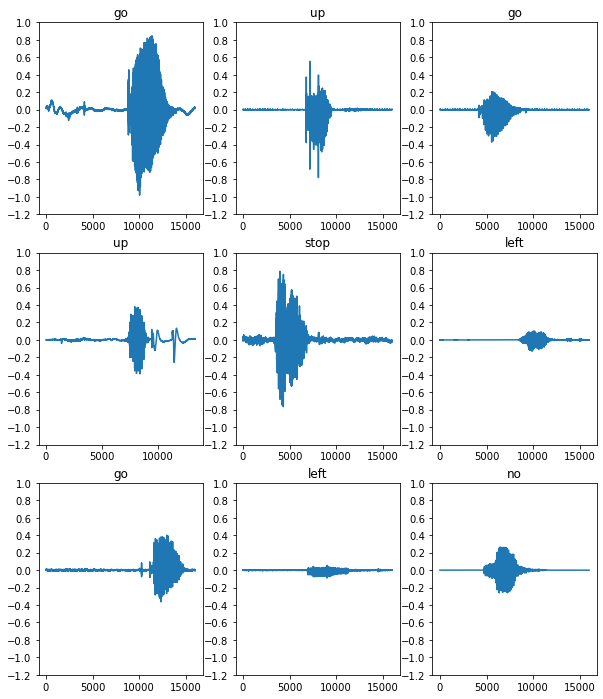

In [11]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10,12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)
plt.show()


In [12]:
def get_spectrogram(waveform):
    zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(
        equal_length, frame_length = 255, frame_step = 128
    )
    spectrogram = tf.abs(spectrogram)


    return spectrogram


In [39]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print("Spectrogram shape:", spectrogram.shape)
print("Audio playback")
display.display(display.Audio(waveform, rate=1600))


Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


NameError: name 'waveform' is not defined

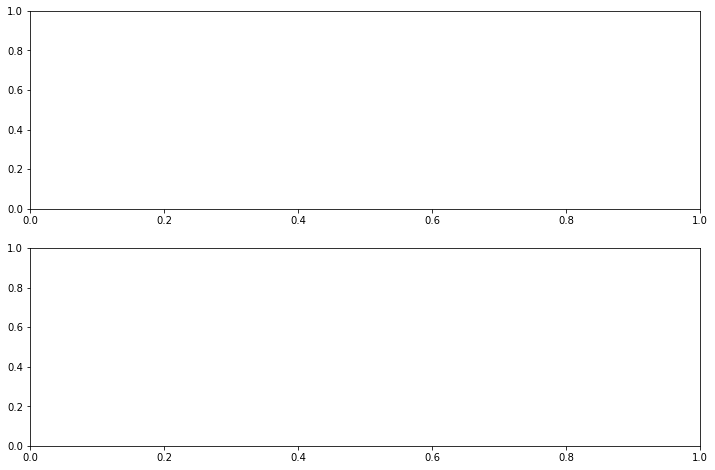

In [13]:
def plot_spectrogram(spectrogram, ax):
    log_spec = np.log(spectrogram.T)
    height = log_spec.shape[0]
    X = np.arange(16000, step=height + 1)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

fig, axes = plt.subplots(2, figsize=(12,8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0,16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title("Spectrogram")
plt.show()


In [14]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(label == commands)
    return spectrogram, label_id


In [15]:

spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)


TypeError: in user code:

    <ipython-input-14-9bb774e86fd8>:4 get_spectrogram_and_label_id  *
        label_id = tf.argmax(label == commands)
    /home/ma/.bin/anaconda3/envs/tensor/lib/python3.8/site-packages/tensorflow/python/ops/math_ops.py:173 argmax_v2  **
        return gen_math_ops.arg_max(input, axis, name=name, output_type=output_type)
    /home/ma/.bin/anaconda3/envs/tensor/lib/python3.8/site-packages/tensorflow/python/ops/gen_math_ops.py:847 arg_max
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /home/ma/.bin/anaconda3/envs/tensor/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py:576 _apply_op_helper
        _SatisfiesTypeConstraint(base_type,
    /home/ma/.bin/anaconda3/envs/tensor/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py:57 _SatisfiesTypeConstraint
        raise TypeError(

    TypeError: Value passed to parameter 'input' has DataType bool not in list of allowed values: float32, float64, int32, uint8, int16, int8, complex64, int64, qint8, quint8, qint32, bfloat16, uint16, complex128, float16, uint32, uint64
